In [1]:
import pandas as pd
import numpy as np

import re
#import pingouin as pg
#from scipy.stats import pearsonr, spearmanr, kendalltau
import matplotlib.pyplot as plt
import sklearn.datasets

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [2]:
def drop_nn(df):
    df = df.select_dtypes(include=['number'])
    return df

### Clean dataframe

In [3]:
df = pd.read_csv("data/clean_data/IPIP_20_test.csv").drop(columns=['Unnamed: 0'])
df.index= df.index+1
df.head(3)

,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10,...,i291,i292,i293,i294,i295,i296,i297,i298,i299,i300
1,5,4,5.0,2,4,2,1,5,4,2,...,1,4,5,5,1,1,2,5,4,2
2,5,1,1.0,2,4,2,1,2,2,5,...,2,2,1,5,2,5,2,1,5,5
3,4,4,5.0,4,5,4,4,4,3,4,...,5,5,5,1,4,4,5,5,2,5


In [4]:
info = pd.read_csv("data/clean_data/IPIP_20_desc_item.csv").drop(columns=['Unnamed: 0'])
info.head(3)

,item#,Item,Sign,Key,Facet
0,i1,Worry about things.,+N1,N1,Anxiety
1,i2,Make friends easily.,+E1,E1,Friendliness
2,i3,Have a vivid imagination.,+O1,O1,Imagination


## Factorial analysis

- Verify if a factorial analysis can be performed by **Bartlett’s test of sphericity** and **Kaiser-Meyer-Olkin (KMO)**

In [5]:
def perform_fa(df):
    chi_square_value,p_value=calculate_bartlett_sphericity(df)
    if p_value > 0.05:
        print(f"P-value=({p_value}). Statistically insignifincant, factorial analaisis can not be performed")
    else:
        print(f"P-value=({p_value}). Statistically significant, factorial analaisis can be performed")

In [6]:
perform_fa(df)

P-value=(0.0). Statistically significant, factorial analaisis can be performed


In [7]:
def perform_fa_KMO(df):
    kmo_all,kmo_model=calculate_kmo(df)
    if kmo_model < 0.6:
        print(f"KMO=({kmo_model}). Proportion of variance NOT suitable for factor analysis")
    else:
        print(f"KMO=({kmo_model}). Proportion of variance suitable for factor analysis")

In [8]:
perform_fa_KMO(df)

/usr/local/lib/python3.7/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


KMO=(0.9742421861895908). Proportion of variance suitable for factor analysis


- Choosing Number of factors by **Kaiser criterion**

In [9]:
def show_num_factors(df):
    fa = FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,method='minres', n_factors=10,
                        rotation='varimax', rotation_kwargs={},use_smc=True)
    fa.fit(df)
    ev, v = fa.get_eigenvalues()
    num_f = len([e for e in ev if e > ev.mean() + 2 * ev.std()])
    res_f = len([e for e in ev if e > 1])
    plt.scatter(range(1,df.shape[1]+1),ev)
    plt.plot(range(1,df.shape[1]+1),ev)
    plt.title('Scree Plot')
    plt.xlabel('Factors')
    plt.ylabel('Eigenvalue')
    plt.grid()
    plt.show()
    return f"Best number of factors: {num_f}. Other possible factors {res_f-num_f}"

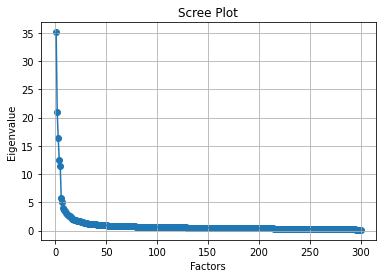

'Best number of factors: 5. Other possible factors 39'

In [10]:
show_num_factors(df)

In [11]:
def best_num_factors(df):
    fa = FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,method='minres', n_factors=10,
                        rotation=None, rotation_kwargs={},use_smc=True)
    fa.fit(df)
    ev, v = fa.get_eigenvalues()
    num_f = len([e for e in ev if e > ev.mean() + 2 * ev.std()])
    return num_f

In [58]:
def num_factors(df):
    fa = FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,method='minres', n_factors=10,
                        rotation=None, rotation_kwargs={},use_smc=True)
    fa.fit(df)
    ev, v = fa.get_eigenvalues()
    res_f = len([e for e in ev if e > 1])
    return res_f

In [12]:
n_fac = best_num_factors(df)

###  Performing Factorial Analysis

#### Analize test:
- To get item correlation with all the **Dimensions**

In [13]:
def fac_an(df, n_factors, name):
    drop_nn(df)
    fa = FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,method='minres', 
                         n_factors=n_factors, rotation='varimax', rotation_kwargs={},use_smc=True)
    fa.fit(df)
    load = pd.DataFrame.from_records(fa.loadings_, columns=([f'{name}'+str(i+1) for i in range(n_factors)]))
    load['item#']= df.columns
    return load

In [14]:
fat = fac_an(df, n_fac, 'dimension')
fat.head(3)

,dimension1,dimension2,dimension3,dimension4,dimension5,item#
0,0.598490,-0.125986,0.106546,0.071941,-0.019155,i1
1,-0.111008,0.607184,0.123381,0.232628,-0.050933,i2
2,0.045407,0.150988,-0.063756,0.016246,0.452346,i3


Include results in info

In [38]:
def add_info(info_df, df, name):
    lis = drop_nn(df).idxmax(axis=1)
    datf = pd.DataFrame()
    datf['item#'] = df['item#'].to_numpy()
    datf[name] = lis
    tot = info_df.join(datf.set_index('item#'), on='item#')
    return tot

In [39]:
inf = add_info(info,fat, 'Dimension')
inf.head(20)

,item#,Item,Sign,Key,Facet,Dimension
0,i1,Worry about things.,+N1,N1,Anxiety,dimension1
1,i2,Make friends easily.,+E1,E1,Friendliness,dimension2
2,i3,Have a vivid imagination.,+O1,O1,Imagination,dimension5
3,i4,Trust others.,+A1,A1,Trust,dimension4
4,i5,Complete tasks successfully.,+C1,C1,Self-Efficacy,dimension3
5,i6,Get angry easily.,+N2,N2,Anger,dimension1
6,i7,Love large parties.,+E2,E2,Gregariousness,dimension2
7,i8,Believe in the importance of art.,+O2,O2,Artistic Interests,dimension5
8,i9,Would never cheat on my taxes.,+A2,A2,Morality,dimension4
9,i10,Like order.,+C2,C2,Orderliness,dimension3


#### Analize dimensions:
- To get item correlation with all the **Facets**

In [40]:
def fac_corr_df(dfv,df,col):
    lis = []
    dfv = drop_nn(dfv)
    df = drop_nn(df)
    for e in range(len(dfv)):
        if dfv.iloc[e][col] == dfv.iloc[e].max():
            lis.append('i'+str(e+1))
    return df[lis]

Create a df with all the items for each dimension

In [62]:
fad = {i:fac_corr_df(fat, df, f"{i}") for i in list(drop_nn(fat).columns)}

,i1,i6,i11,i13,i16,i21,i26,i31,i36,i41,...,i251,i253,i256,i261,i266,i271,i276,i281,i286,i296
1,5,2,1,5,2,2,1,3,4,4,...,2,2,4,1,1,1,2,5,2,1
2,5,2,5,5,5,5,5,5,4,5,...,5,5,5,1,5,5,2,5,5,5
3,4,4,2,4,1,2,1,1,4,1,...,1,5,4,2,2,2,4,2,1,4


In [63]:
print(list(drop_nn(fat).columns))
fad['dimension1'].head(3)

['dimension1', 'dimension2', 'dimension3', 'dimension4', 'dimension5']


,i1,i6,i11,i13,i16,i21,i26,i31,i36,i41,...,i251,i253,i256,i261,i266,i271,i276,i281,i286,i296
1,5,2,1,5,2,2,1,3,4,4,...,2,2,4,1,1,1,2,5,2,1
2,5,2,5,5,5,5,5,5,4,5,...,5,5,5,1,5,5,2,5,5,5
3,4,4,2,4,1,2,1,1,4,1,...,1,5,4,2,2,2,4,2,1,4


Get the best factors for each df:

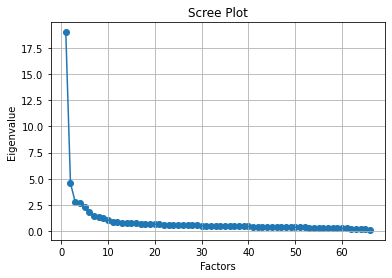

Best number of factors: 1. Other possible factors 9


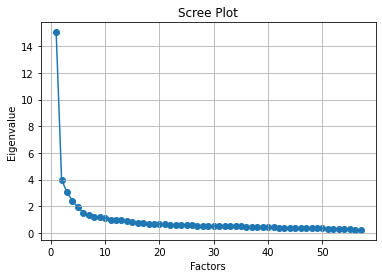

Best number of factors: 1. Other possible factors 10


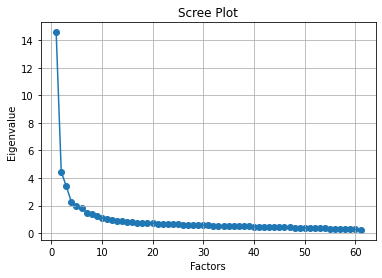

Best number of factors: 1. Other possible factors 10


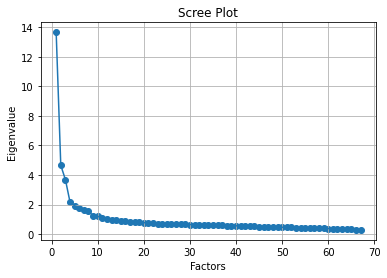

Best number of factors: 2. Other possible factors 10


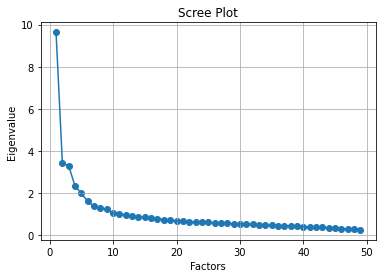

Best number of factors: 1. Other possible factors 10


In [64]:
for e in list(drop_nn(fat).columns):
    print(show_num_factors(fad[e]))

In [65]:
n_factors = {i:num_factors(fad[i]) for i in list(drop_nn(fat).columns)}

In [67]:
n_factors['dimension2']

11

In [69]:
facets = {i:fac_an(fad[i], n_factors[i], f"{i}_Facet") for i in list(drop_nn(fat).columns)}

In [71]:
facets['dimension3'].head(3)

,dimension3_Facet1,dimension3_Facet2,dimension3_Facet3,dimension3_Facet4,dimension3_Facet5,dimension3_Facet6,dimension3_Facet7,dimension3_Facet8,dimension3_Facet9,dimension3_Facet10,dimension3_Facet11,item#
0,0.489572,0.180635,0.122865,0.219940,0.098128,0.134307,0.184635,0.071149,0.056448,0.059059,0.167611,i5
1,0.162758,0.117355,0.587198,0.048465,0.316627,0.012970,0.100099,0.017187,-0.032434,0.168655,-0.060934,i10
2,0.014820,0.165492,0.180881,0.074275,0.781262,0.107664,0.084098,-0.009106,0.046085,-0.009445,0.017954,i15


In [41]:
info1 = add_info(inf, f1, 'Faceta')
info1

,item#,Item,Sign,Key,Facet,Dimension,Faceta
0,i1,Worry about things.,+N1,N1,Anxiety,dimension1,Facet7
1,i2,Make friends easily.,+E1,E1,Friendliness,dimension2,NaN
2,i3,Have a vivid imagination.,+O1,O1,Imagination,dimension5,NaN
3,i4,Trust others.,+A1,A1,Trust,dimension4,NaN
4,i5,Complete tasks successfully.,+C1,C1,Self-Efficacy,dimension3,NaN
...,...,...,...,...,...,...,...
295,i296,Am calm even in tense situations.,-N6,N6,Vulnerability,dimension1,Facet4
296,i297,Seldom joke around.,-E6,E6,Cheerfulness,dimension2,NaN
297,i298,Like to stand during the national anthem.,-O6,O6,Liberalism,dimension5,NaN
298,i299,Can't stand weak people.,-A6,A6,Sympathy,dimension4,NaN


In [ ]:
fatt = fac_an(df,30)

In [ ]:
fatt.head(20)